# Study of Correlation between Contact Maps and pLMs Attention Scores in the context of Ubiquitin

# Introduction

Protein language models are computational tools inspired by natural language processing techniques to analyze and understand protein sequences. Using large datasets of protein sequences, they capture patterns that represent biological functions, structures, and interactions. This enables predictions of protein folding, function, and even the design of novel proteins. These models hold potential for advancements in drug discovery, enzyme engineering, and understanding of diseases at the molecular level.


However, with pLMs being hard to interpret, there is little understood about why and how they make those predictions. The objective of this project is to analyze if the attention patterns in pLMs correlate with protein-related properties. In particular, we focus on how attention correlates with contact maps. We use the pLM ESM2 and select Ubiquitin as a test protein.

*Ubiquitin protein*

Ubiquitin is a small regulatory protein found in almost all tissues of eukaryotic organisms, where it plays a crucial role in various cellular processes, most notably in protein degradation via the ubiquitin-proteasome pathway. It is composed of 76 amino acids, and its sequence is highly conserved across species due to its critical role in maintaining cellular homeostasis.

3D Visualization of Ubiquitin structure

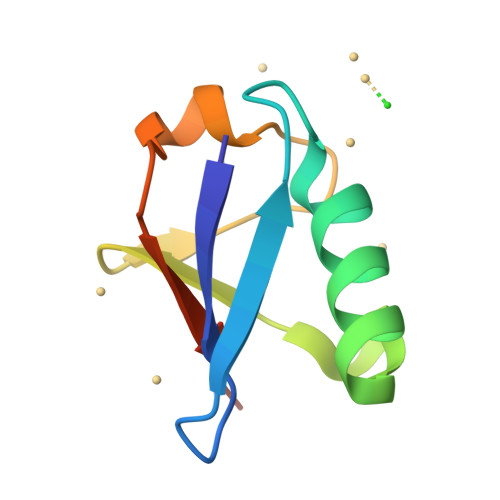

**Secondary structure:**

*   Five β-strands (β1–β5): Form a β-sheet that provides stability to the protein core.
*   One α-helix (α1): Located between β-strands, running antiparallel to the β-sheet.
*   One 3₁₀ helix: A short helix near the C-terminal region (residues 56–59), which contributes to the C-terminal tail region.

**Tertiary Structure:**

* The β-sheet forms the core of the protein, while the α-helix and the loops are located on the surface, allowing interaction with other proteins.
* The structure is stabilized by hydrophobic interactions between the β-strands and the α-helix, as well as hydrogen bonds that hold the β-sheet together.
* The C-terminal tail of ubiquitin (residues 72–76) is especially important because it provides the glycine (Gly76) residue that links ubiquitin to target proteins via an isopeptide bond.


# Methods

### Coordinate Extraction and Contact Map Generation

*Coordinate extraction*

We use the C-alpha atom coordinates of a protein from a PDB file to identify the amino acid in the protein sequence. The C-alpha atom is commonly used to represent the backbone structure of a protein, as it is present in all amino acids.

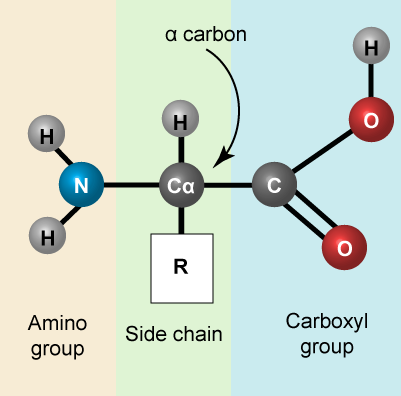

*Contact map generation*

From the coordinates, we can construct a contact map, which is a binary matrix indicating whether two residues are within a certain cutoff distance (e.g., 8 Å, a commonly used threshold for defining contacts).

 Once the structure is loaded, we calculate the distance between every pair of C-alpha atoms (or centroid atoms) for the amino acids. If the distance is below the chosen cutoff, we mark those two amino acids as being "in contact."
This gives us a contact map
𝐶
(
𝑖
,
𝑗
)
C(i,j), where
𝐶
(
𝑖
,
𝑗
)
=
1
C(i,j)=1 if residues
𝑖
i and
𝑗
j are in contact, and 0 otherwise.

### Model Selection

**Encoder-based models**, such as **BERT**, **TAPE**, and **ProteinBERT**, rely on **bidirectional attention**, making them better suited for capturing the **global context** of the entire sequence. These models use multi-head self-attention mechanisms that allow the model to attend to all positions in the input sequence simultaneously. This characteristic is particularly important when correlating attention patterns with spatial contact maps in proteins, as it enables the model to capture **long-range dependencies** between amino acids that may be **distant in sequence but close in 3D structure**.

For example, in a protein's 3D conformation, residues that are physically near each other may play key roles in its function, even if they are separated by dozens of amino acids in the linear sequence. An **encoder-only model**, which attends to all positions at once, can efficiently model these long-distance interactions, making it ideal for tasks involving the prediction of contact maps.

Several key **encoder-only models** include:

1. **TAPE (Transformer version)**:
   - TAPE uses a transformer encoder with bidirectional self-attention, which allows the model to attend to all parts of the input sequence. This makes it effective for capturing both local and global sequence contexts, essential for predicting protein stability, contact maps, and other sequence-based features.

2. **ProteinBERT**:
   - Built on the BERT architecture, ProteinBERT leverages bidirectional attention and has been trained on large protein datasets like UniRef90. Its ability to capture context across the entire protein sequence makes it highly effective for tasks involving protein property prediction, including contact map prediction and functional site identification.

3. **ESM (Evolutionary Scale Modeling) models**:
   - The **ESM family** includes **ESM-1b** and **ESM-2**, both of which use transformer encoders with bidirectional attention. These models, trained on hundreds of millions of protein sequences, have been shown to excel at sequence modeling and protein structure prediction due to their ability to capture the full context of the protein sequence.

In contrast, **decoder-only models** (like GPT-based models such as **ProtGPT2**) use **unidirectional attention**, meaning they only attend to previous positions in the sequence. While these models perform well for autoregressive tasks like protein sequence generation, they may miss important correlations between distant amino acids that are **spatially close in 3D** but far apart in the sequence. This limitation makes decoder-only models less ideal for tasks where understanding **long-range dependencies** across the entire sequence is crucial, such as correlating attention patterns with contact maps.

### Selected model: ESM-2

**ESM-2** stands out as a particularly strong candidate for this task for several reasons:

1. **Bidirectional Attention**:
   ESM-2 uses a **transformer encoder** with **multi-head self-attention**, which allows the model to attend to all positions in the input sequence. This property is crucial when working with protein contact maps, as amino acids that are far apart in the sequence might be in close proximity in the 3D structure. ESM-2’s ability to capture these long-range interactions is essential for accurately correlating attention heads with spatial contact maps.

2. **Model Size Flexibility**:
   ESM-2 offers various model sizes, from smaller 8M-parameter versions to larger 3B and 15B models, allowing researchers to choose a version that balances **memory constraints** with **performance needs**. For our task, the 150M parameter version strikes a good balance between computational efficiency and representational power, easily fitting within a 16GB GPU memory limit while still offering robust performance for sequence-to-structure tasks.

3. **State-of-the-Art Performance**:
   ESM-2 is trained on a **massive dataset of 600 million protein sequences** from UniRef90, filtered and deduplicated to remove noise. This extensive training makes ESM-2 particularly adept at **sequence modeling** and **structure prediction**, often outperforming earlier models like TAPE and ProteinBERT on protein-specific benchmarks. It has been shown to effectively capture the relationships between sequence features and structural properties, making it ideal for studying contact maps.

4. **Attention Mechanism**:
   ESM-2 provides easy access to **multi-head self-attention scores** from each layer, which is crucial for the task of analyzing how attention correlates with protein contact maps. By extracting these attention scores, we can directly evaluate whether the model focuses on amino acid pairs that are in spatial proximity, helping to open the black box of how protein language models make predictions.

5. **Strong Structural Representation**:
   ESM-2 has demonstrated state-of-the-art performance in **protein structure prediction**, thanks to its ability to model **evolutionary and structural signals**. Its pre-training on large-scale protein datasets makes it highly effective at capturing the intricate relationships between a protein’s sequence and its 3D structure, which is exactly the kind of insight needed when studying contact maps.


# Results

In [1]:
!pip install Bio esm

In [2]:
from Bio.PDB import PDBParser
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt
from esm import pretrained
import random

/usr/local/lib/python3.10/dist-packages/google/cloud/storage/transfer_manager.py:30: UserWarning: The module `transfer_manager` is a preview feature. Functionality and API may change. This warning will be removed in a future release.
  warnings.warn(


In [3]:
# Set the Seaborn style to pastel
sns.set(style="whitegrid")

## Extract Protein Coordinates and Compute Contact Map

In [4]:
# Provide the path to the PDB file
ubiquitin_pdb = "/content/1yiw.pdb"

In [ ]:
def print_pdb_info(pdb_file):
    parser = PDBParser(QUIET=True)  # QUIET=True suppresses warnings
    structure = parser.get_structure('Ubiquitin', pdb_file)  # Parse the PDB file

    # Loop through all models, chains, and residues
    for model in structure:
        print(f"Model: {model.id}")
        for chain in model:
            print(f"  Chain: {chain.id}")
            for residue in chain:
                resname = residue.get_resname()  # Get the residue name (e.g., ALA, GLY)
                res_id = residue.id[1]  # Get the residue ID (sequence number)
                print(f"    Residue: {resname} {res_id}")
                for atom in residue:
                    atom_name = atom.get_name()  # Get atom name (e.g., CA, N, C)
                    coord = atom.get_coord()  # Get the (X, Y, Z) coordinates
                    print(f"      Atom: {atom_name}, Coordinates: {coord}")

# Call the function to print information
print_pdb_info(ubiquitin_pdb)


Model: 0
  Chain: A
    Residue: LEU 1
      Atom: N, Coordinates: [39.003 14.14  10.446]
      Atom: CA, Coordinates: [38.309 13.491 11.575]
      Atom: C, Coordinates: [38.998 12.156 11.84 ]
      Atom: O, Coordinates: [39.144 11.387 10.916]
      Atom: CB, Coordinates: [36.845 13.246 11.162]
      Atom: CG, Coordinates: [35.693 13.186 12.14 ]
      Atom: CD1, Coordinates: [34.528 12.409 11.552]
      Atom: CD2, Coordinates: [36.113 12.583 13.435]
    Residue: GLN 2
      Atom: N, Coordinates: [39.471 11.827 13.042]
      Atom: CA, Coordinates: [40.107 10.55  13.3  ]
      Atom: C, Coordinates: [39.114  9.734 14.081]
      Atom: O, Coordinates: [38.586 10.22  15.062]
      Atom: CB, Coordinates: [41.419 10.695 14.079]
      Atom: CG, Coordinates: [42.216  9.362 14.163]
      Atom: CD, Coordinates: [43.566  9.592 14.804]
      Atom: OE1, Coordinates: [43.653  9.835 16.016]
      Atom: NE2, Coordinates: [44.627  9.557 13.993]
    Residue: ILE 3
      Atom: N, Coordinates: [38.812  8.51

The last to glycine residues (n 75 and 76) are not inlcuded in the PDB file.

In [5]:
target_chain_id = "C"  # Correct chain ID for ubiquitin

def get_ca_coordinates_and_names(pdb_file, chain_id):
    parser = PDBParser()
    structure = parser.get_structure('ubiquitin', pdb_file)

    coords = []
    pdb_seq = []

    for model in structure:
        for chain in model:
            if chain.id == chain_id:  # Only consider the specified chain
                for residue in chain:
                    if residue.has_id('CA'):  # Ensure it has a C-alpha atom
                        coords.append(residue['CA'].get_coord())
                        pdb_seq.append(residue.get_resname())  # Get the residue name

    return np.array(coords), pdb_seq

# Get C-alpha coordinates and residue names for the specified chain
coords, pdb_seq = get_ca_coordinates_and_names(ubiquitin_pdb, target_chain_id)

# Check the length of the coordinates and residue names
print("Number of C-alpha coordinates:", len(coords))  # Should be 76 for ubiquitin
print("Residue names:", pdb_seq)  # Print the list of residue names


Number of C-alpha coordinates: 74
Residue names: ['LEU', 'GLN', 'ILE', 'PHE', 'VAL', 'LYS', 'THR', 'LEU', 'THR', 'GLY', 'LYS', 'THR', 'ILE', 'THR', 'LEU', 'GLU', 'VAL', 'GLU', 'PRO', 'SER', 'ASP', 'THR', 'ILE', 'GLU', 'ASN', 'VAL', 'LYS', 'ALA', 'LYS', 'ILE', 'GLN', 'ASP', 'LYS', 'GLU', 'GLY', 'ILE', 'PRO', 'PRO', 'ASP', 'GLN', 'GLN', 'ARG', 'LEU', 'ILE', 'PHE', 'ALA', 'GLY', 'LYS', 'GLN', 'LEU', 'GLU', 'ASP', 'GLY', 'ARG', 'THR', 'LEU', 'SER', 'ASP', 'TYR', 'ASN', 'ILE', 'GLN', 'LYS', 'GLU', 'SER', 'THR', 'LEU', 'HIS', 'LEU', 'VAL', 'LEU', 'ARG', 'LEU', 'ARG']


/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2648.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2656.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 2663.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2668.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2744.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 2814.
  warnings.warn(


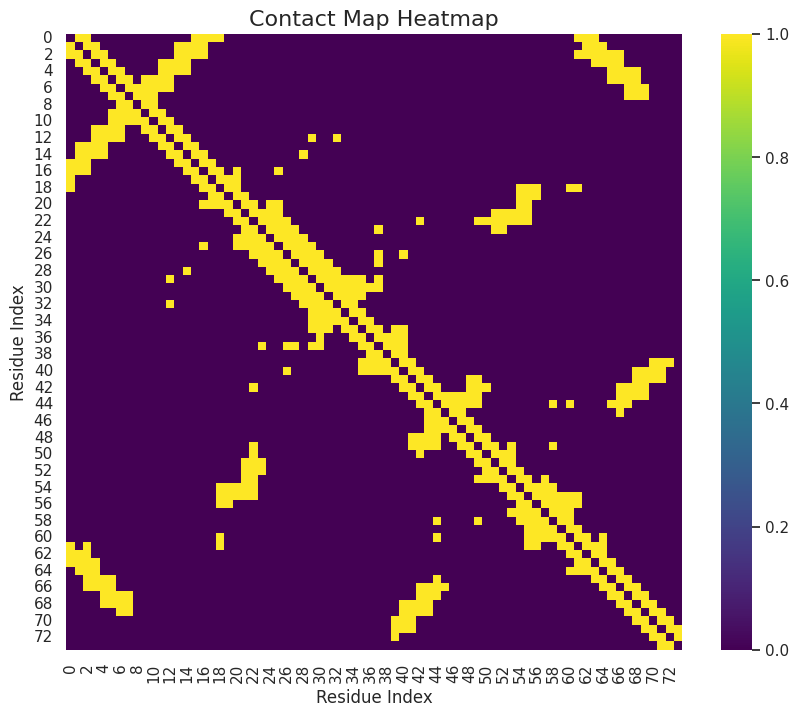

In [7]:
# Function to compute the contact map
def compute_contact_map(coords, cutoff=8.0):
    n = len(coords)
    contact_map = np.zeros((n, n))  # Initialize an empty contact map
    for i in range(n):
        for j in range(i+1, n):
            dist = np.linalg.norm(coords[i] - coords[j])  # Compute Euclidean distance
            if dist < cutoff:  # If distance is less than the cutoff, set contact
                contact_map[i, j] = contact_map[j, i] = 1  # Symmetric contact map
    return contact_map

# Compute the contact map using the coordinates
contact_map = compute_contact_map(coords)

# Plot the contact map as a heatmap
def plot_contact_map(contact_map):
    plt.figure(figsize=(10, 8))  # Set the figure size
    sns.heatmap(contact_map, cmap="viridis", cbar=True, square=True)  # Create a heatmap
    plt.title("Contact Map Heatmap", fontsize=16)  # Add a title
    plt.xlabel("Residue Index")  # Label for the x-axis
    plt.ylabel("Residue Index")  # Label for the y-axis
    plt.show()  # Display the plot

# Call the function to plot the contact map
plot_contact_map(contact_map)


## Experiment 1: ESM2 650M param

### Extract Attention Maps

In [37]:
# Format amino acid sequence to format required by ESM2
format_mapping = {
    'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E',
    'PHE': 'F', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
    'LYS': 'K', 'LEU': 'L', 'MET': 'M', 'ASN': 'N',
    'PRO': 'P', 'GLN': 'Q', 'ARG': 'R', 'SER': 'S',
    'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'
}


# Convert to single-letter codes
ubiquitin_sequence = ''.join(format_mapping[aa] for aa in pdb_seq)

# Output the result
print(ubiquitin_sequence)

LQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLR


In [38]:
# Load model
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")
model = AutoModelForMaskedLM.from_pretrained("facebook/esm2_t33_650M_UR50D")
model.eval()  # Set model to evaluation mode

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


EsmForMaskedLM(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 1280, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 1280, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-32): 33 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=1280, out_features=1280, bias=True)
              (key): Linear(in_features=1280, out_features=1280, bias=True)
              (value): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((1280,), eps=1e-05, 

In [39]:
# Check tokenization of the input sequence
inputs = tokenizer(ubiquitin_sequence, return_tensors="pt", padding=False)

# Print the token IDs and the decoded tokens
print("Token IDs:", inputs['input_ids'])
print("Decoded Tokens:", tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]))


Token IDs: tensor([[ 0,  4, 16, 12, 18,  7, 15, 11,  4, 11,  6, 15, 11, 12, 11,  4,  9,  7,
          9, 14,  8, 13, 11, 12,  9, 17,  7, 15,  5, 15, 12, 16, 13, 15,  9,  6,
         12, 14, 14, 13, 16, 16, 10,  4, 12, 18,  5,  6, 15, 16,  4,  9, 13,  6,
         10, 11,  4,  8, 13, 19, 17, 12, 16, 15,  9,  8, 11,  4, 21,  4,  7,  4,
         10,  4, 10,  2]])
Decoded Tokens: ['<cls>', 'L', 'Q', 'I', 'F', 'V', 'K', 'T', 'L', 'T', 'G', 'K', 'T', 'I', 'T', 'L', 'E', 'V', 'E', 'P', 'S', 'D', 'T', 'I', 'E', 'N', 'V', 'K', 'A', 'K', 'I', 'Q', 'D', 'K', 'E', 'G', 'I', 'P', 'P', 'D', 'Q', 'Q', 'R', 'L', 'I', 'F', 'A', 'G', 'K', 'Q', 'L', 'E', 'D', 'G', 'R', 'T', 'L', 'S', 'D', 'Y', 'N', 'I', 'Q', 'K', 'E', 'S', 'T', 'L', 'H', 'L', 'V', 'L', 'R', 'L', 'R', '<eos>']


In [40]:
# Function to compute attention scores from the model
def compute_attention_scores(model, tokenizer, sequence):
    # Tokenize the input sequence
    inputs = tokenizer(sequence, return_tensors="pt", padding=True)

    # Get outputs from the model
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    # Extract the attention scores from all layers and heads
    attentions = outputs.attentions  # This will be a list of attention tensors for each layer
    return attentions

# Get attention scores
attention_scores = compute_attention_scores(model, tokenizer, ubiquitin_sequence)

Maximum Attention Score: 1.0
Minimum Attention Score: 4.909847654583233e-17
Mean Attention Score: 0.0132
Median Attention Score: 0.0047
Standard Deviation: 0.0450
25th Percentile (Q1): 0.0012
75th Percentile (Q3): 0.0113


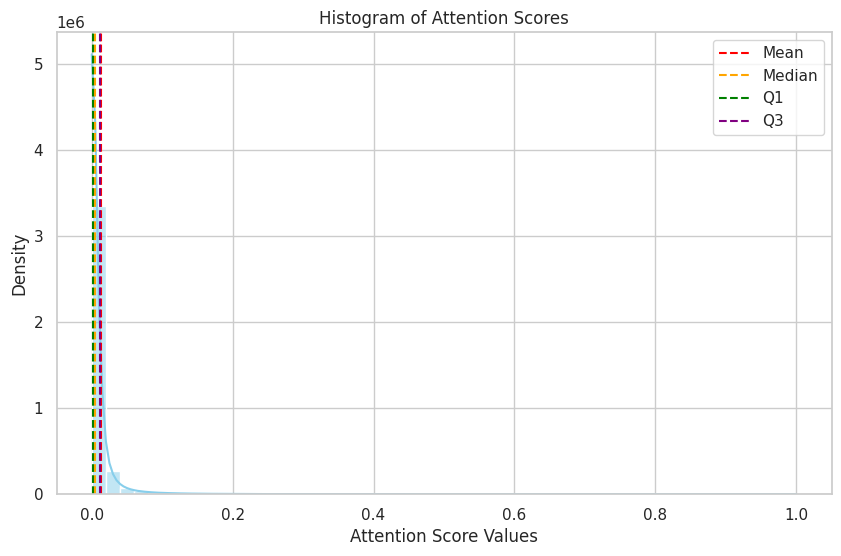

In [41]:
# Flatten the attention scores for histogram
all_attention_values = []
for layer_att in attention_scores:
    all_attention_values.append(layer_att.flatten().cpu().numpy())

# Concatenate values from all layers
all_attention_values = np.concatenate(all_attention_values)

# Calculate statistical information
max_attention_value = np.max(all_attention_values)
min_attention_value = np.min(all_attention_values)
mean_attention_value = np.mean(all_attention_values)
median_attention_value = np.median(all_attention_values)
std_attention_value = np.std(all_attention_values)
q1_attention_value = np.percentile(all_attention_values, 25)
q3_attention_value = np.percentile(all_attention_values, 75)

# Print the statistical information
print(f"Maximum Attention Score: {max_attention_value}")
print(f"Minimum Attention Score: {min_attention_value}")
print(f"Mean Attention Score: {mean_attention_value:.4f}")
print(f"Median Attention Score: {median_attention_value:.4f}")
print(f"Standard Deviation: {std_attention_value:.4f}")
print(f"25th Percentile (Q1): {q1_attention_value:.4f}")
print(f"75th Percentile (Q3): {q3_attention_value:.4f}")

# Plot histogram of the attention scores using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(all_attention_values, bins=50, color='skyblue', kde=True)
plt.title('Histogram of Attention Scores')
plt.xlabel('Attention Score Values')
plt.ylabel('Density')
plt.axvline(mean_attention_value, color='red', linestyle='--', label='Mean')
plt.axvline(median_attention_value, color='orange', linestyle='--', label='Median')
plt.axvline(q1_attention_value, color='green', linestyle='--', label='Q1')
plt.axvline(q3_attention_value, color='purple', linestyle='--', label='Q3')
plt.legend()
plt.grid(True)
plt.show()


### Correlate High-Attention Pairs with Contact Map

In [42]:
def analyze_attention_with_contact(attention_scores, contact_map, threshold):
    n_layers = len(attention_scores)
    results = []
    head_high_attention_counts = []

    start_idx = 1  # Skip the <cls> token
    end_idx = 75   # Only go up to the last amino acid (excluding <eos>)

    for layer_idx in range(n_layers):
        layer_att = attention_scores[layer_idx]
        num_heads = layer_att.size(1)

        for head_idx in range(num_heads):
            att_matrix = layer_att[0, head_idx].cpu().numpy()
            att_matrix = att_matrix[start_idx:end_idx, start_idx:end_idx]

            high_attention_pairs = att_matrix > threshold

            total_pairs = high_attention_pairs.size
            total_high_attention_pairs = np.sum(high_attention_pairs)

            # Store high attention pair percentage
            high_attention_percentage = total_high_attention_pairs / total_pairs if total_pairs > 0 else 0
            head_high_attention_counts.append(high_attention_percentage)

            # Calculate the proportion of high attention pairs that are in contact
            contact_pairs = np.sum(high_attention_pairs * contact_map)
            proportion_contact = (contact_pairs / total_high_attention_pairs) if total_high_attention_pairs > 0 else 0

            results.append(proportion_contact)

    return np.mean(results), np.mean(head_high_attention_counts)  # Return average proportion and mean high attention percentage


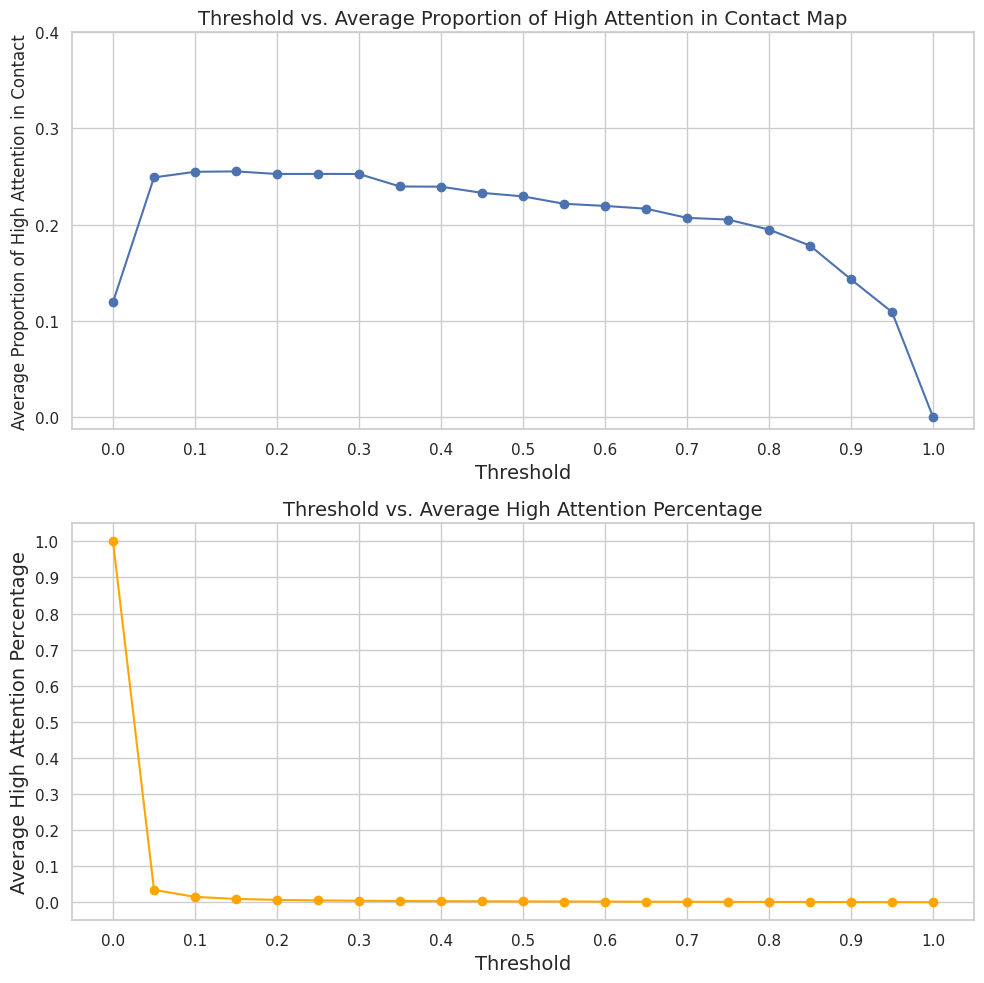

In [44]:
# Test a range of thresholds
thresholds = np.linspace(0, 1, 21)  # From 0.0 to 1.0 with 21 steps
proportions = []
average_high_attention_percentages = []

for threshold in thresholds:
    avg_proportion, avg_high_attention_percentage = analyze_attention_with_contact(attention_scores, contact_map, threshold)
    proportions.append(avg_proportion)
    average_high_attention_percentages.append(avg_high_attention_percentage)  # Store single value for each threshold

# Create the first plot for average proportions in contact map
plt.figure(figsize=(10, 10))

# Plot 1: Average Proportion of High Attention in Contact Map
plt.subplot(2, 1, 1)
plt.plot(thresholds, proportions, marker='o', linestyle='-', color='b')
plt.title('Threshold vs. Average Proportion of High Attention in Contact Map', fontsize=14)
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('Average Proportion of High Attention in Contact', fontsize=12)
plt.grid(True)
plt.xticks(np.arange(0, 1.1, 0.1))  # Set x-ticks
plt.yticks(np.arange(0, 0.41, 0.1))  # Set y-ticks

# Plot 2: Average High Attention Percentage
plt.subplot(2, 1, 2)
plt.plot(thresholds, average_high_attention_percentages, marker='o', linestyle='-', color='orange')
plt.title('Threshold vs. Average High Attention Percentage', fontsize=14)
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('Average High Attention Percentage', fontsize=14)
plt.grid(True)
plt.xticks(np.arange(0, 1.1, 0.1))  # Set x-ticks
plt.yticks(np.arange(0, 1.1, 0.1))  # Set y-ticks

plt.tight_layout()  # Adjust layout
plt.show()


In [23]:
# Function to analyze attention scores and contact map
def analyze_attention_with_contact(attention_scores, contact_map, threshold=0.6):
    n_layers = len(attention_scores)
    results = []

    # Define the range to ignore special tokens
    start_idx = 1  # Skip the <cls> token
    end_idx = 75   # Only go up to the last amino acid (excluding <eos>)

    for layer_idx in range(n_layers):
        layer_att = attention_scores[layer_idx]  # Shape: (batch_size, num_heads, seq_len, seq_len)
        num_heads = layer_att.size(1)  # Number of attention heads

        for head_idx in range(num_heads):
            att_matrix = layer_att[0, head_idx].cpu().numpy()  # Get the attention matrix for this head

            # Slice the attention matrix to ignore special tokens
            att_matrix = att_matrix[start_idx:end_idx, start_idx:end_idx]  # Shape: (74, 74)

            # Identify high attention pairs
            high_attention_pairs = att_matrix > threshold

            # Calculate the proportion of high-attention pairs that are in contact
            total_high_attention_pairs = np.sum(high_attention_pairs)
            contact_pairs = np.sum(high_attention_pairs * contact_map)

            if total_high_attention_pairs > 0:
                proportion_contact = contact_pairs / total_high_attention_pairs
            else:
                proportion_contact = 0

            results.append((layer_idx, head_idx, proportion_contact))

    return results

# Analyze the attention scores with the contact map
attention_contact_results = analyze_attention_with_contact(attention_scores, contact_map, threshold=0.05)

# Print results
for layer_idx, head_idx, proportion in attention_contact_results:
    print(f"Layer: {layer_idx}, Head: {head_idx}, Proportion of High Attention in Contact: {proportion:.4f}")


Layer: 0, Head: 0, Proportion of High Attention in Contact: 0.3636
Layer: 0, Head: 1, Proportion of High Attention in Contact: 0.0000
Layer: 0, Head: 2, Proportion of High Attention in Contact: 0.0000
Layer: 0, Head: 3, Proportion of High Attention in Contact: 0.0000
Layer: 0, Head: 4, Proportion of High Attention in Contact: 0.0000
Layer: 0, Head: 5, Proportion of High Attention in Contact: 0.4615
Layer: 0, Head: 6, Proportion of High Attention in Contact: 0.0000
Layer: 0, Head: 7, Proportion of High Attention in Contact: 0.7000
Layer: 0, Head: 8, Proportion of High Attention in Contact: 0.2824
Layer: 0, Head: 9, Proportion of High Attention in Contact: 0.0000
Layer: 0, Head: 10, Proportion of High Attention in Contact: 0.0000
Layer: 0, Head: 11, Proportion of High Attention in Contact: 0.1800
Layer: 0, Head: 12, Proportion of High Attention in Contact: 0.0000
Layer: 0, Head: 13, Proportion of High Attention in Contact: 0.0000
Layer: 0, Head: 14, Proportion of High Attention in Contac

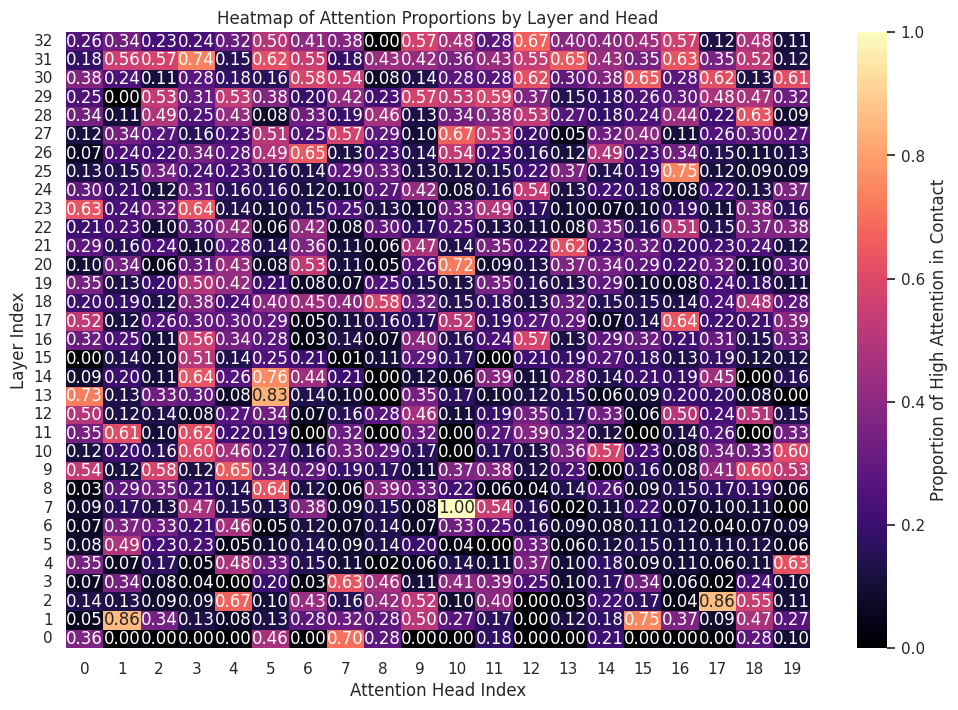

In [25]:
# Prepare data for heatmap
layers = [result[0] for result in attention_contact_results]
heads = [result[1] for result in attention_contact_results]

num_layers = max(layers) + 1
num_heads = max(heads) + 1

# Initialize a matrix to hold proportions
heatmap_data = np.zeros((num_layers, num_heads))

# Fill the heatmap data
for layer, head, proportion in attention_contact_results:
    heatmap_data[layer, head] = proportion

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='magma', annot=True, fmt='.2f', cbar_kws={'label': 'Proportion of High Attention in Contact'})
plt.xlabel('Attention Head Index')
plt.ylabel('Layer Index')
plt.title('Heatmap of Attention Proportions by Layer and Head')
plt.xticks(ticks=np.arange(num_heads) + 0.5, labels=np.arange(num_heads))
plt.yticks(ticks=np.arange(num_layers) + 0.5, labels=np.arange(num_layers))
# Reverse the y-axis
plt.gca().invert_yaxis()
plt.show()


In [30]:
def plot_attention_maps(attention_scores, contact_map, layer_index, head_index, threshold=0.05):

    # Get the attention matrix for the specified head from the specified layer
    attention_matrix = attention_scores[layer_index][0, head_index].cpu().numpy()

    # Create binary attention map by applying the threshold
    binary_attention_map = (attention_matrix > threshold).astype(float)

    # Plotting the matrices
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot original contact map
    sns.heatmap(contact_map, ax=axes[0], cmap='viridis', cbar=True)
    axes[0].set_title("Original Contact Map")
    axes[0].set_xlabel("Residue Index")
    axes[0].set_ylabel("Residue Index")

    # Plot original attention map for the selected head
    sns.heatmap(attention_matrix, ax=axes[1], cmap='magma', cbar=True)
    axes[1].set_title(f"Attention Map (Layer {layer_index}, Head {head_index})")
    axes[1].set_xlabel("Residue Index")
    axes[1].set_ylabel("Residue Index")

    # Plot binary attention map
    sns.heatmap(binary_attention_map, ax=axes[2], cmap='magma', cbar=True)
    axes[2].set_title("Binary Attention Map (Threshold 0.05)")
    axes[2].set_xlabel("Residue Index")
    axes[2].set_ylabel("Residue Index")

    plt.tight_layout()
    plt.show()


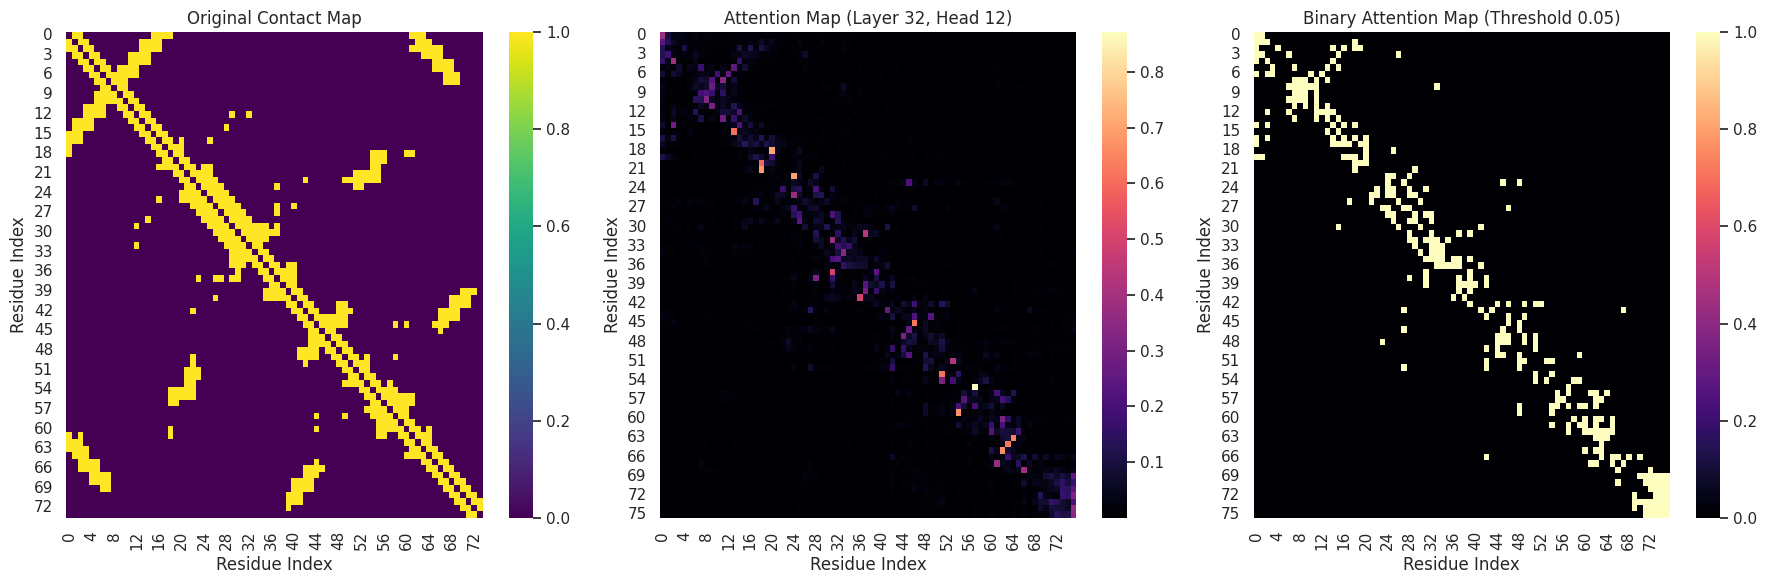

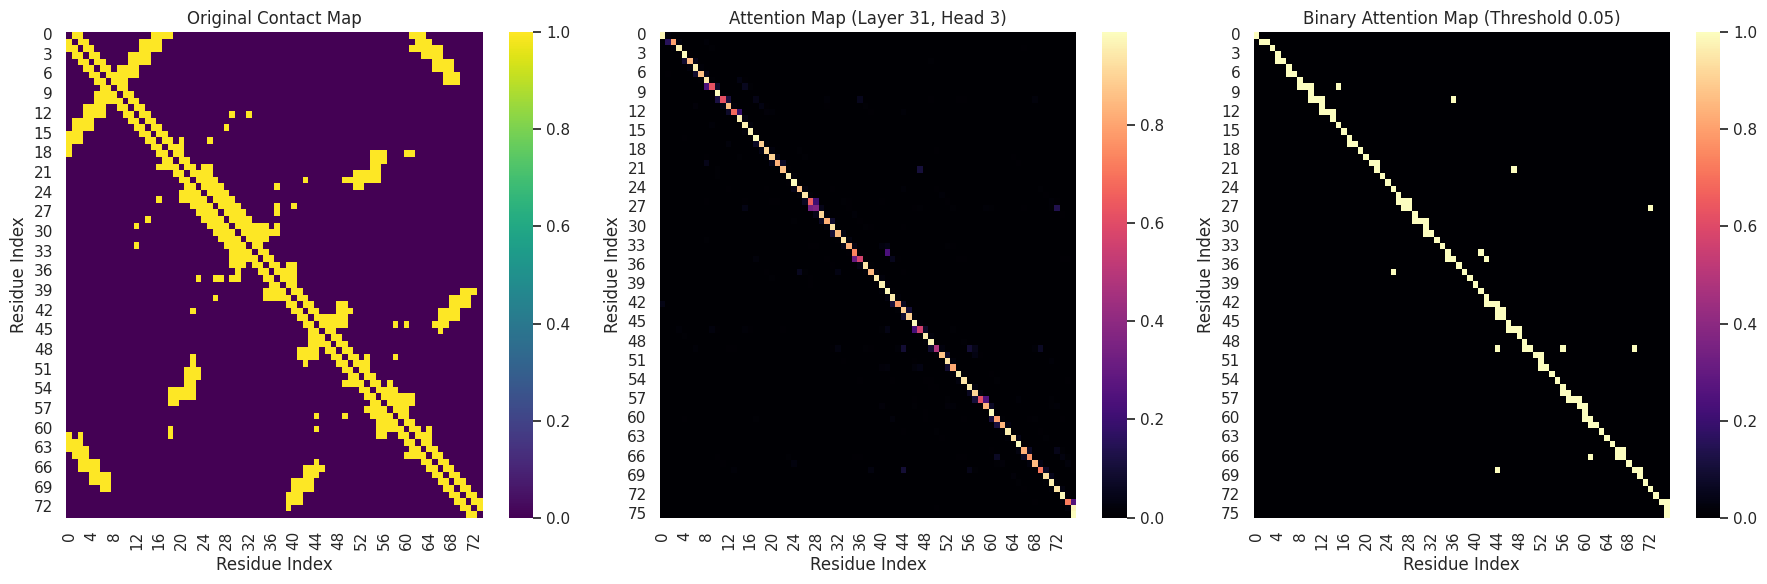

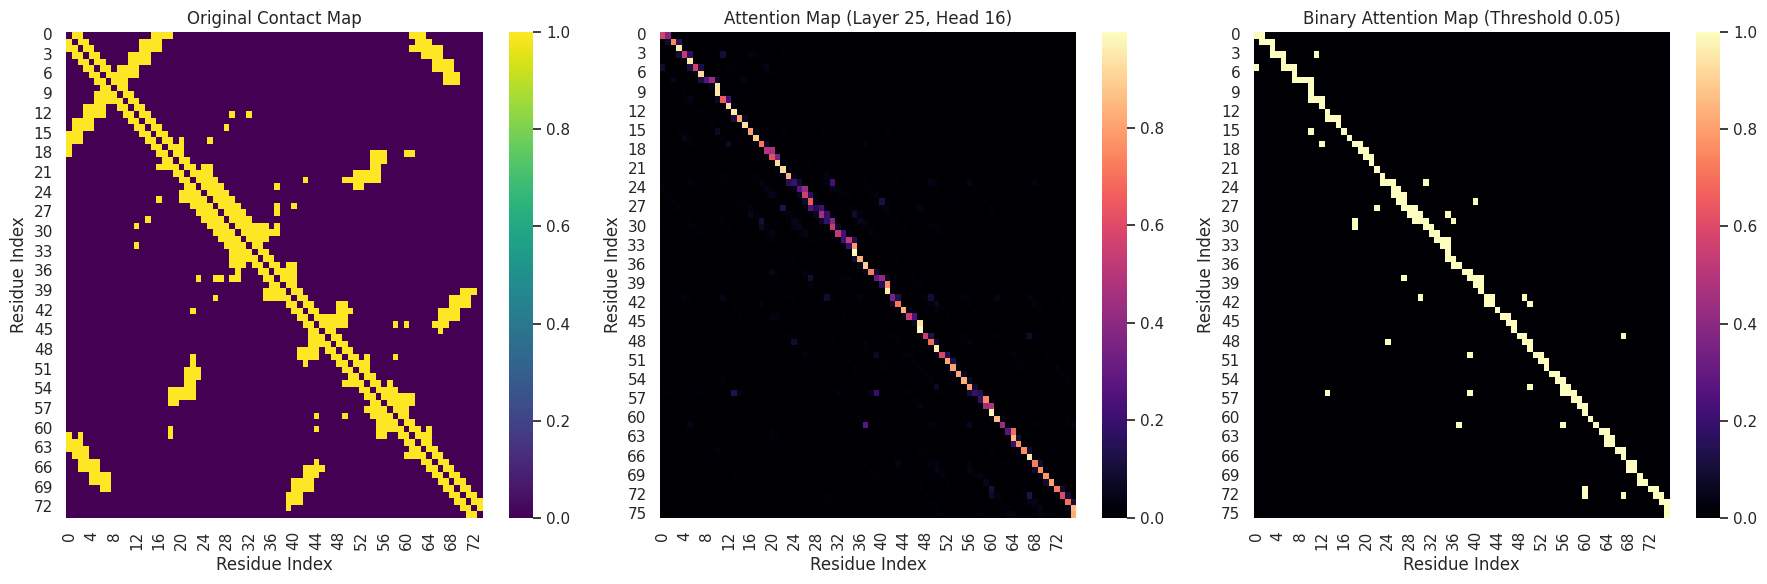

In [34]:
# Plot head with high correlation from last layers
plot_attention_maps(attention_scores, contact_map, layer_index=32, head_index=12)

plot_attention_maps(attention_scores, contact_map, layer_index=31, head_index=3)

plot_attention_maps(attention_scores, contact_map, layer_index=25, head_index=16)


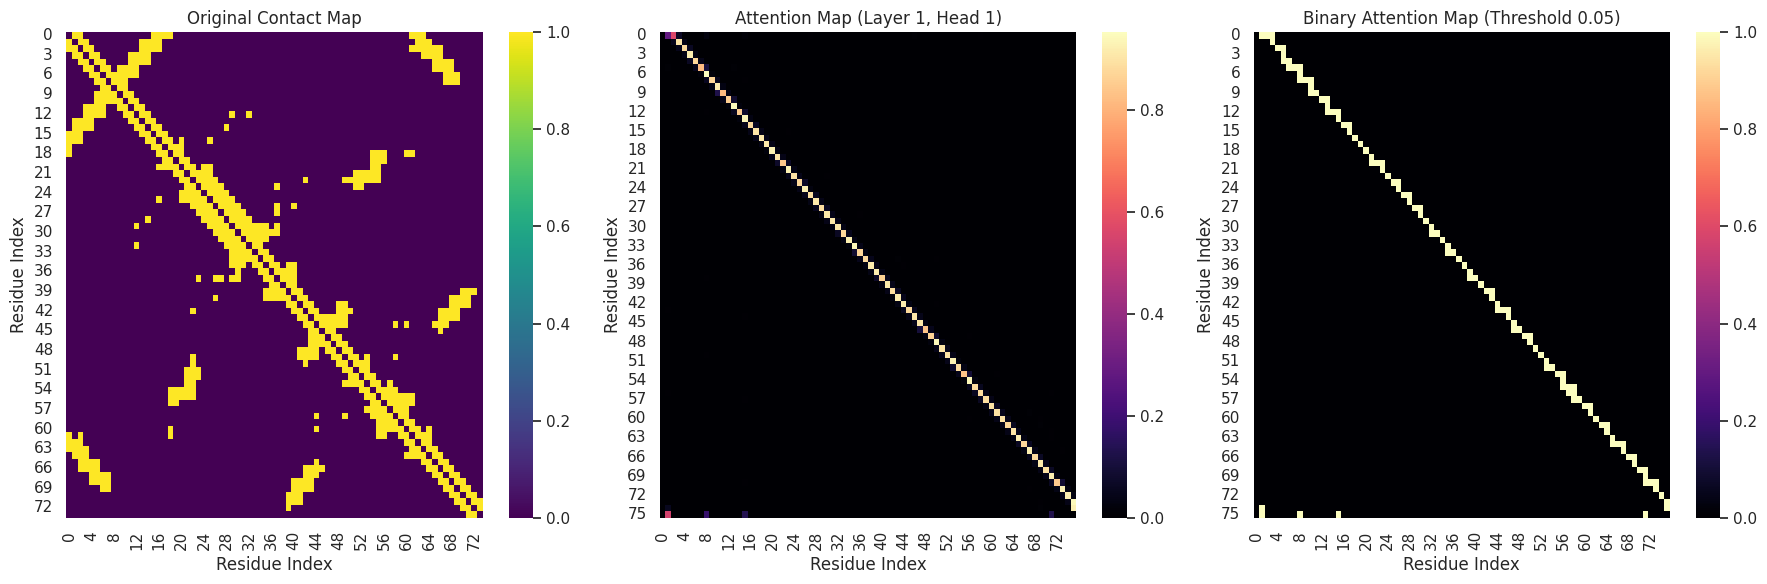

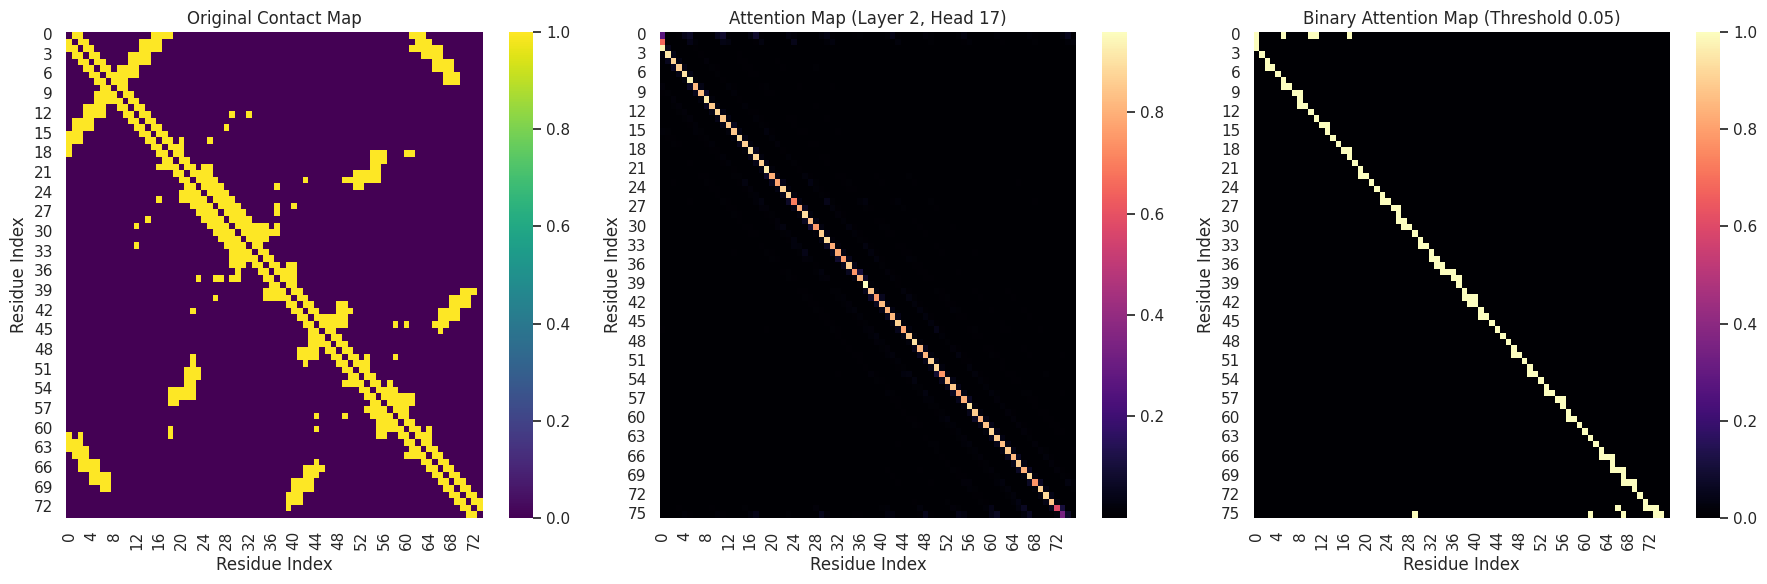

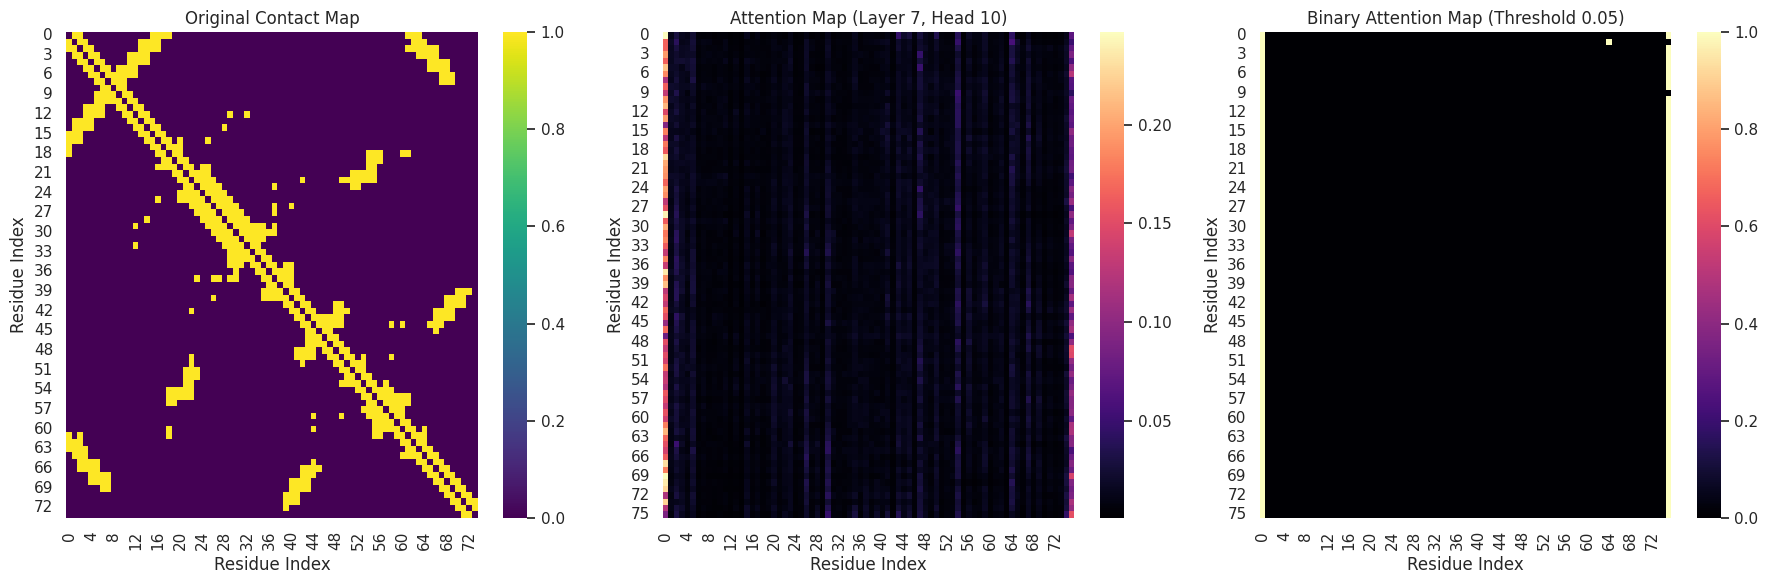

In [35]:
# Plot head with high correlation from first layers
plot_attention_maps(attention_scores, contact_map, layer_index=1, head_index=1)

plot_attention_maps(attention_scores, contact_map, layer_index=2, head_index=17)

plot_attention_maps(attention_scores, contact_map, layer_index=7, head_index=10)
